In [14]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy import stats
from scipy.optimize import minimize
from typing import Dict, List, Tuple
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Import custom modules
from brats_loader import BraTSLoader
from pca_analysis import PCAAnalyzer
from data_loader import MRIDataLoader

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading Configuration

In [15]:
# Configure data paths
BRATS_DATA_PATH = '../data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
RESULTS_PATH = Path('../results/pca_comparison')
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Check if data exists
data_exists = Path(BRATS_DATA_PATH).exists()
print(f"BraTS data path: {BRATS_DATA_PATH}")
print(f"Data exists: {data_exists}")
print(f"Results will be saved to: {RESULTS_PATH}")

BraTS data path: ../data/raw/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Data exists: True
Results will be saved to: ..\results\pca_comparison


In [16]:
# Initialize BraTS loader
if data_exists:
    brats_loader = BraTSLoader(BRATS_DATA_PATH)
    subjects = brats_loader.get_subject_list()
    print(f"Found {len(subjects)} subjects in BraTS2020 training dataset")
    print(f"First 5 subjects: {subjects[:5]}")
else:
    print("ERROR: BraTS data not found. Please download the dataset first.")
    subjects = []

INFO:brats_loader:Found 369 subjects


Found 369 subjects in BraTS2020 training dataset
First 5 subjects: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005']


## 2. Helper Functions for PCA Analysis

In [17]:
def prepare_multimodal_features(slices: Dict[str, np.ndarray], 
                                modalities: List[str] = ['t1', 't1ce', 't2', 'flair']) -> np.ndarray:
    """
    Prepare multi-modal feature matrix from MRI slices.
    
    Args:
        slices: Dictionary containing MRI modalities
        modalities: List of modalities to include
    
    Returns:
        Feature matrix of shape (n_pixels, n_modalities)
    """
    features = []
    for mod in modalities:
        if mod in slices:
            # Flatten and normalize each modality
            img = slices[mod].flatten()
            # Normalize to [0, 1]
            if img.max() > img.min():
                img = (img - img.min()) / (img.max() - img.min())
            features.append(img)
    
    return np.column_stack(features)


def prepare_segmentation_features(seg: np.ndarray) -> np.ndarray:
    """
    Prepare segmentation as features for PCA.
    Uses one-hot encoding of segmentation labels.
    
    Args:
        seg: Segmentation mask with shape (H, W)
    
    Returns:
        Feature matrix of shape (n_pixels, n_classes)
    """
    seg_flat = seg.flatten()
    unique_labels = np.unique(seg_flat)
    n_classes = len(unique_labels)
    n_pixels = len(seg_flat)
    
    # One-hot encode
    features = np.zeros((n_pixels, n_classes))
    for i, label in enumerate(unique_labels):
        features[:, i] = (seg_flat == label).astype(float)
    
    return features


def compute_pca_metrics(X: np.ndarray, n_components: int = None) -> Dict:
    """
    Compute comprehensive PCA metrics for given data.
    
    Args:
        X: Data matrix (n_samples, n_features)
        n_components: Number of components to keep (None = all)
    
    Returns:
        Dictionary of PCA metrics
    """
    pca = PCAAnalyzer(n_components=n_components)
    pca.fit(X)
    X_transformed = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_transformed)
    
    # Compute reconstruction error
    mse = np.mean((X - X_reconstructed) ** 2)
    rmse = np.sqrt(mse)
    
    # Normalized reconstruction error
    X_variance = np.var(X)
    normalized_error = mse / X_variance if X_variance > 0 else 0
    
    # Explained variance
    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var_ratio)
    
    return {
        'pca': pca,
        'transformed': X_transformed,
        'reconstructed': X_reconstructed,
        'mse': mse,
        'rmse': rmse,
        'normalized_error': normalized_error,
        'eigenvalues': pca.eigenvalues_,
        'explained_variance_ratio': explained_var_ratio,
        'cumulative_variance': cumulative_var,
        'n_components': len(pca.eigenvalues_),
        'total_variance_explained': cumulative_var[-1] if len(cumulative_var) > 0 else 0
    }


print("Helper functions defined successfully!")

Helper functions defined successfully!


## 3. Process All BraTS Subjects

We will:
1. Load all subjects in the training dataset
2. Extract middle axial slices (where tumors are typically present)
3. Apply PCA to both original multi-modal images and segmentation masks
4. Collect metrics for statistical analysis

In [18]:
# Storage for results
results = {
    'original': [],  # PCA on original multi-modal images
    'segmentation': []  # PCA on segmentation masks
}

# Number of subjects to process (use all available)
n_subjects = len(subjects)
print(f"Processing {n_subjects} subjects...")

# Process each subject
for i, subject_id in enumerate(tqdm(subjects, desc="Processing subjects")):
    try:
        # Load subject with tumor slice
        slices, slice_idx = brats_loader.load_subject_with_tumor_slice(subject_id, axis=2)
        
        # Skip if no segmentation
        if 'seg' not in slices or slices['seg'] is None:
            continue
        
        # Check if tumor is present
        seg = slices['seg']
        if np.sum(seg > 0) == 0:
            continue
        
        # ===== PCA ON ORIGINAL MULTI-MODAL IMAGES =====
        X_original = prepare_multimodal_features(slices)
        metrics_original = compute_pca_metrics(X_original, n_components=None)
        
        results['original'].append({
            'subject_id': subject_id,
            'slice_idx': slice_idx,
            'n_features': X_original.shape[1],
            'n_pixels': X_original.shape[0],
            **metrics_original
        })
        
        # ===== PCA ON SEGMENTATION MASKS =====
        X_seg = prepare_segmentation_features(seg)
        metrics_seg = compute_pca_metrics(X_seg, n_components=None)
        
        results['segmentation'].append({
            'subject_id': subject_id,
            'slice_idx': slice_idx,
            'n_features': X_seg.shape[1],
            'n_pixels': X_seg.shape[0],
            'n_tumor_pixels': np.sum(seg > 0),
            'tumor_percentage': 100 * np.sum(seg > 0) / seg.size,
            **metrics_seg
        })
        
    except Exception as e:
        print(f"\nError processing {subject_id}: {str(e)}")
        continue

print(f"\n✓ Successfully processed:")
print(f"  - {len(results['original'])} subjects with original images")
print(f"  - {len(results['segmentation'])} subjects with segmentation masks")

Processing 369 subjects...


Processing subjects:   0%|          | 0/369 [00:00<?, ?it/s]INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii with shape (240, 240, 155)
INFO:data_loader:Loaded ..\data\raw\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii with shape (240, 240, 155)
INFO:brats_loader:Loaded subject BraTS20_Training_001 with 5 volumes
INFO:brats_loader:Selected slice 67 with


✓ Successfully processed:
  - 368 subjects with original images
  - 368 subjects with segmentation masks


## 4. Statistical Analysis and Maximum Likelihood Estimation (MLE)

### Theory

We model the reconstruction error distribution and perform MLE to estimate parameters.

**Assumption**: Reconstruction errors follow a Gaussian distribution:
$$\epsilon \sim \mathcal{N}(\mu, \sigma^2)$$

**Log-likelihood for Gaussian**:
$$\log L(\mu, \sigma | \epsilon_1, \ldots, \epsilon_n) = -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(\epsilon_i - \mu)^2$$

**MLE estimates**:
- $\hat{\mu}_{MLE} = \frac{1}{n}\sum_{i=1}^{n}\epsilon_i$
- $\hat{\sigma}^2_{MLE} = \frac{1}{n}\sum_{i=1}^{n}(\epsilon_i - \hat{\mu})^2$

In [19]:
def gaussian_log_likelihood(params: np.ndarray, data: np.ndarray) -> float:
    """
    Compute negative log-likelihood for Gaussian distribution.
    
    Args:
        params: [mu, sigma]
        data: Sample data
    
    Returns:
        Negative log-likelihood (for minimization)
    """
    mu, sigma = params
    n = len(data)
    
    if sigma <= 0:
        return 1e10  # Invalid parameter
    
    log_likelihood = -n/2 * np.log(2 * np.pi) - n/2 * np.log(sigma**2) - \
                     np.sum((data - mu)**2) / (2 * sigma**2)
    
    return -log_likelihood  # Return negative for minimization


def fit_gaussian_mle(data: np.ndarray) -> Tuple[float, float, Dict]:
    """
    Fit Gaussian distribution using Maximum Likelihood Estimation.
    
    Args:
        data: Sample data
    
    Returns:
        Tuple of (mu_mle, sigma_mle, fit_info)
    """
    # Analytical MLE solutions
    mu_mle = np.mean(data)
    sigma_mle = np.std(data, ddof=0)  # MLE uses N, not N-1
    
    # Verify with numerical optimization
    initial_guess = [mu_mle, sigma_mle]
    result = minimize(
        gaussian_log_likelihood,
        initial_guess,
        args=(data,),
        method='Nelder-Mead'
    )
    
    mu_opt, sigma_opt = result.x
    
    # Compute confidence intervals (95%)
    n = len(data)
    se_mu = sigma_mle / np.sqrt(n)
    ci_mu = stats.norm.interval(0.95, loc=mu_mle, scale=se_mu)
    
    # Chi-square for variance
    chi2_lower = stats.chi2.ppf(0.025, n-1)
    chi2_upper = stats.chi2.ppf(0.975, n-1)
    ci_sigma = (np.sqrt((n-1) * sigma_mle**2 / chi2_upper),
                np.sqrt((n-1) * sigma_mle**2 / chi2_lower))
    
    fit_info = {
        'mu_analytical': mu_mle,
        'sigma_analytical': sigma_mle,
        'mu_numerical': mu_opt,
        'sigma_numerical': sigma_opt,
        'n_samples': n,
        'log_likelihood': -result.fun,
        'ci_mu': ci_mu,
        'ci_sigma': ci_sigma,
        'optimization_success': result.success
    }
    
    return mu_mle, sigma_mle, fit_info


print("MLE functions defined successfully!")

MLE functions defined successfully!


In [20]:
# Extract reconstruction errors for MLE
errors_original = np.array([r['rmse'] for r in results['original']])
errors_seg = np.array([r['rmse'] for r in results['segmentation']])

print("=" * 80)
print("MAXIMUM LIKELIHOOD ESTIMATION RESULTS")
print("=" * 80)

# MLE for original images
print("\n1. ORIGINAL MULTI-MODAL IMAGES:")
print("-" * 80)
mu_orig, sigma_orig, fit_orig = fit_gaussian_mle(errors_original)
print(f"  MLE Estimate (μ):        {mu_orig:.6f}")
print(f"  95% CI for μ:            [{fit_orig['ci_mu'][0]:.6f}, {fit_orig['ci_mu'][1]:.6f}]")
print(f"  MLE Estimate (σ):        {sigma_orig:.6f}")
print(f"  95% CI for σ:            [{fit_orig['ci_sigma'][0]:.6f}, {fit_orig['ci_sigma'][1]:.6f}]")
print(f"  Log-likelihood:          {fit_orig['log_likelihood']:.2f}")
print(f"  Sample size:             {fit_orig['n_samples']}")

# MLE for segmentation
print("\n2. SEGMENTATION MASKS:")
print("-" * 80)
mu_seg, sigma_seg, fit_seg = fit_gaussian_mle(errors_seg)
print(f"  MLE Estimate (μ):        {mu_seg:.6f}")
print(f"  95% CI for μ:            [{fit_seg['ci_mu'][0]:.6f}, {fit_seg['ci_mu'][1]:.6f}]")
print(f"  MLE Estimate (σ):        {sigma_seg:.6f}")
print(f"  95% CI for σ:            [{fit_seg['ci_sigma'][0]:.6f}, {fit_seg['ci_sigma'][1]:.6f}]")
print(f"  Log-likelihood:          {fit_seg['log_likelihood']:.2f}")
print(f"  Sample size:             {fit_seg['n_samples']}")

print("\n" + "=" * 80)

MAXIMUM LIKELIHOOD ESTIMATION RESULTS

1. ORIGINAL MULTI-MODAL IMAGES:
--------------------------------------------------------------------------------
  MLE Estimate (μ):        0.000000
  95% CI for μ:            [0.000000, 0.000000]
  MLE Estimate (σ):        0.000000
  95% CI for σ:            [0.000000, 0.000000]
  Log-likelihood:          13194.44
  Sample size:             368

2. SEGMENTATION MASKS:
--------------------------------------------------------------------------------
  MLE Estimate (μ):        0.000000
  95% CI for μ:            [0.000000, 0.000000]
  MLE Estimate (σ):        0.000000
  95% CI for σ:            [0.000000, 0.000000]
  Log-likelihood:          13420.53
  Sample size:             368



## 5. Hypothesis Testing

**Null Hypothesis (H₀)**: PCA reconstruction error is the same for original images and segmentation masks

**Alternative Hypothesis (H₁)**: PCA reconstruction error differs between original images and segmentation masks

We perform:
1. Two-sample t-test
2. Mann-Whitney U test (non-parametric)
3. Kolmogorov-Smirnov test (distribution comparison)

In [21]:
print("=" * 80)
print("HYPOTHESIS TESTING: Original vs Segmentation PCA Performance")
print("=" * 80)

# Two-sample t-test
t_stat, t_pval = stats.ttest_ind(errors_original, errors_seg)
print("\n1. TWO-SAMPLE T-TEST:")
print("-" * 80)
print(f"  t-statistic:             {t_stat:.4f}")
print(f"  p-value:                 {t_pval:.6e}")
print(f"  Reject H₀ (α=0.05):      {t_pval < 0.05}")

# Mann-Whitney U test (non-parametric)
u_stat, u_pval = stats.mannwhitneyu(errors_original, errors_seg, alternative='two-sided')
print("\n2. MANN-WHITNEY U TEST:")
print("-" * 80)
print(f"  U-statistic:             {u_stat:.4f}")
print(f"  p-value:                 {u_pval:.6e}")
print(f"  Reject H₀ (α=0.05):      {u_pval < 0.05}")

# Kolmogorov-Smirnov test
ks_stat, ks_pval = stats.ks_2samp(errors_original, errors_seg)
print("\n3. KOLMOGOROV-SMIRNOV TEST:")
print("-" * 80)
print(f"  KS-statistic:            {ks_stat:.4f}")
print(f"  p-value:                 {ks_pval:.6e}")
print(f"  Reject H₀ (α=0.05):      {ks_pval < 0.05}")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(errors_original)-1) * np.var(errors_original, ddof=1) + 
                       (len(errors_seg)-1) * np.var(errors_seg, ddof=1)) / 
                      (len(errors_original) + len(errors_seg) - 2))
cohens_d = (np.mean(errors_original) - np.mean(errors_seg)) / pooled_std
print("\n4. EFFECT SIZE:")
print("-" * 80)
print(f"  Cohen's d:               {cohens_d:.4f}")
print(f"  Effect size interpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("Small")
elif abs(cohens_d) < 0.5:
    print("Medium")
else:
    print("Large")

print("\n" + "=" * 80)

HYPOTHESIS TESTING: Original vs Segmentation PCA Performance

1. TWO-SAMPLE T-TEST:
--------------------------------------------------------------------------------
  t-statistic:             19.5765
  p-value:                 5.509637e-69
  Reject H₀ (α=0.05):      True

2. MANN-WHITNEY U TEST:
--------------------------------------------------------------------------------
  U-statistic:             119029.0000
  p-value:                 7.909152e-71
  Reject H₀ (α=0.05):      True

3. KOLMOGOROV-SMIRNOV TEST:
--------------------------------------------------------------------------------
  KS-statistic:            0.6087
  p-value:                 7.026924e-64
  Reject H₀ (α=0.05):      True

4. EFFECT SIZE:
--------------------------------------------------------------------------------
  Cohen's d:               1.4432
  Effect size interpretation: Large



## 6. Comprehensive Descriptive Statistics

In [22]:
# Create comprehensive statistics dataframe
def compute_statistics(data: np.ndarray, name: str) -> pd.DataFrame:
    """
    Compute comprehensive descriptive statistics.
    """
    stats_dict = {
        'Metric': name,
        'Count': len(data),
        'Mean': np.mean(data),
        'Std': np.std(data, ddof=1),
        'Min': np.min(data),
        '25%': np.percentile(data, 25),
        'Median': np.median(data),
        '75%': np.percentile(data, 75),
        'Max': np.max(data),
        'IQR': np.percentile(data, 75) - np.percentile(data, 25),
        'Skewness': stats.skew(data),
        'Kurtosis': stats.kurtosis(data)
    }
    return pd.DataFrame([stats_dict])

# Reconstruction errors
stats_orig_rmse = compute_statistics(errors_original, 'Original RMSE')
stats_seg_rmse = compute_statistics(errors_seg, 'Segmentation RMSE')

# MSE
mse_original = np.array([r['mse'] for r in results['original']])
mse_seg = np.array([r['mse'] for r in results['segmentation']])
stats_orig_mse = compute_statistics(mse_original, 'Original MSE')
stats_seg_mse = compute_statistics(mse_seg, 'Segmentation MSE')

# Explained variance
var_orig = np.array([r['total_variance_explained'] for r in results['original']])
var_seg = np.array([r['total_variance_explained'] for r in results['segmentation']])
stats_orig_var = compute_statistics(var_orig, 'Original Var. Explained')
stats_seg_var = compute_statistics(var_seg, 'Segmentation Var. Explained')

# Combine all statistics
all_stats = pd.concat([
    stats_orig_rmse, stats_seg_rmse,
    stats_orig_mse, stats_seg_mse,
    stats_orig_var, stats_seg_var
], ignore_index=True)

print("\n" + "=" * 120)
print("COMPREHENSIVE DESCRIPTIVE STATISTICS")
print("=" * 120)
print(all_stats.to_string(index=False))
print("=" * 120)


COMPREHENSIVE DESCRIPTIVE STATISTICS
                     Metric  Count         Mean          Std          Min          25%       Median          75%          Max          IQR  Skewness  Kurtosis
              Original RMSE    368 1.452080e-16 6.500632e-17 4.826274e-17 9.790715e-17 1.290460e-16 1.793208e-16 4.400307e-16 8.141361e-17  1.255688  2.071338
          Segmentation RMSE    368 6.978402e-17 3.516757e-17 1.217526e-17 4.513189e-17 6.454614e-17 8.560042e-17 2.700867e-16 4.046853e-17  1.337846  3.136026
               Original MSE    368 2.529970e-32 2.507988e-32 2.329292e-33 9.585811e-33 1.665288e-32 3.215597e-32 1.936270e-31 2.257016e-32  2.787890 11.462681
           Segmentation MSE    368 6.103207e-33 6.938728e-33 1.482370e-34 2.036888e-33 4.166214e-33 7.327450e-33 7.294683e-32 5.290562e-33  3.799590 25.198989
    Original Var. Explained    368 1.000000e+00 1.035077e-16 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.000000e+00 1.110223e-16       NaN       NaN
Segmenta

## 7. Visualization: Reconstruction Error Distributions

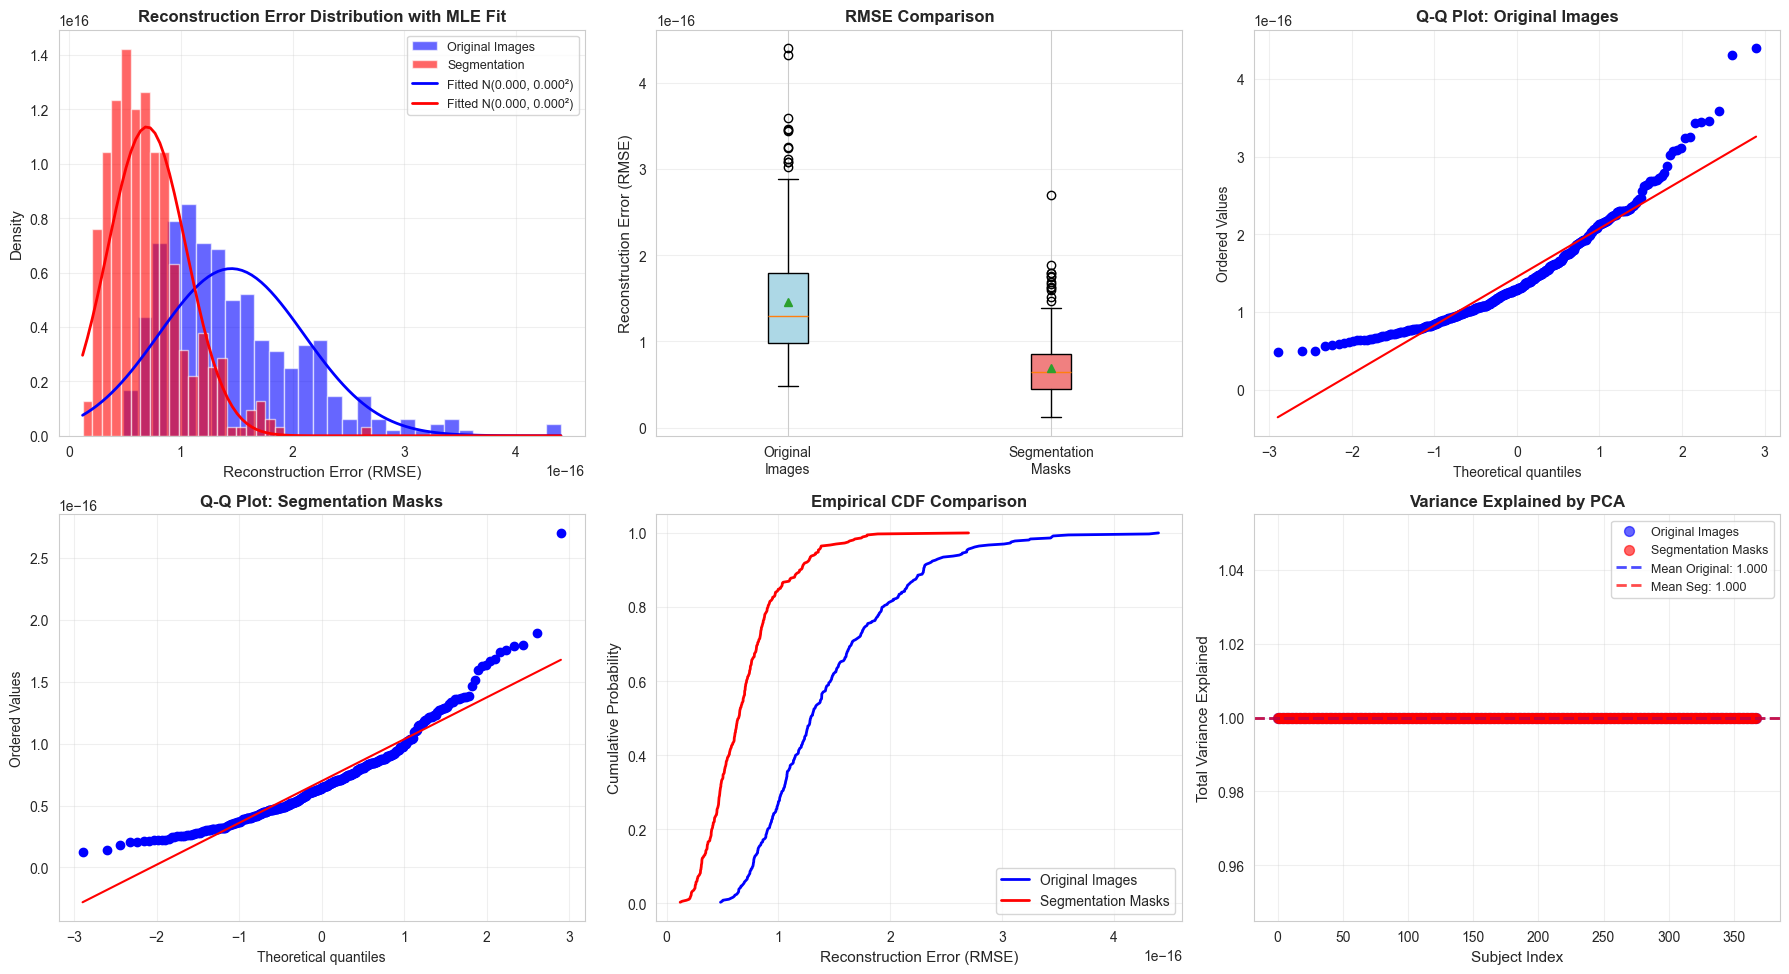

✓ Distribution plots saved!


In [23]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Histogram comparison
ax = axes[0, 0]
ax.hist(errors_original, bins=30, alpha=0.6, label='Original Images', color='blue', density=True)
ax.hist(errors_seg, bins=30, alpha=0.6, label='Segmentation', color='red', density=True)

# Overlay fitted Gaussian distributions
x_range = np.linspace(min(errors_original.min(), errors_seg.min()),
                      max(errors_original.max(), errors_seg.max()), 100)
ax.plot(x_range, stats.norm.pdf(x_range, mu_orig, sigma_orig), 
        'b-', linewidth=2, label=f'Fitted N({mu_orig:.3f}, {sigma_orig:.3f}²)')
ax.plot(x_range, stats.norm.pdf(x_range, mu_seg, sigma_seg), 
        'r-', linewidth=2, label=f'Fitted N({mu_seg:.3f}, {sigma_seg:.3f}²)')

ax.set_xlabel('Reconstruction Error (RMSE)', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Reconstruction Error Distribution with MLE Fit', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 2. Box plot comparison
ax = axes[0, 1]
box_data = [errors_original, errors_seg]
bp = ax.boxplot(box_data, labels=['Original\nImages', 'Segmentation\nMasks'],
                patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
ax.set_ylabel('Reconstruction Error (RMSE)', fontsize=11)
ax.set_title('RMSE Comparison', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 3. Q-Q plot for normality check
ax = axes[0, 2]
stats.probplot(errors_original, dist="norm", plot=ax)
ax.set_title('Q-Q Plot: Original Images', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 4. Q-Q plot for segmentation
ax = axes[1, 0]
stats.probplot(errors_seg, dist="norm", plot=ax)
ax.set_title('Q-Q Plot: Segmentation Masks', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# 5. Cumulative distribution comparison
ax = axes[1, 1]
sorted_orig = np.sort(errors_original)
sorted_seg = np.sort(errors_seg)
cdf_orig = np.arange(1, len(sorted_orig) + 1) / len(sorted_orig)
cdf_seg = np.arange(1, len(sorted_seg) + 1) / len(sorted_seg)

ax.plot(sorted_orig, cdf_orig, 'b-', linewidth=2, label='Original Images')
ax.plot(sorted_seg, cdf_seg, 'r-', linewidth=2, label='Segmentation Masks')
ax.set_xlabel('Reconstruction Error (RMSE)', fontsize=11)
ax.set_ylabel('Cumulative Probability', fontsize=11)
ax.set_title('Empirical CDF Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 6. Variance explained comparison
ax = axes[1, 2]
ax.scatter(range(len(var_orig)), var_orig, alpha=0.6, s=50, label='Original Images', color='blue')
ax.scatter(range(len(var_seg)), var_seg, alpha=0.6, s=50, label='Segmentation Masks', color='red')
ax.axhline(np.mean(var_orig), color='blue', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean Original: {np.mean(var_orig):.3f}')
ax.axhline(np.mean(var_seg), color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean Seg: {np.mean(var_seg):.3f}')
ax.set_xlabel('Subject Index', fontsize=11)
ax.set_ylabel('Total Variance Explained', fontsize=11)
ax.set_title('Variance Explained by PCA', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'pca_comparison_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribution plots saved!")

## 8. Eigenvalue Analysis

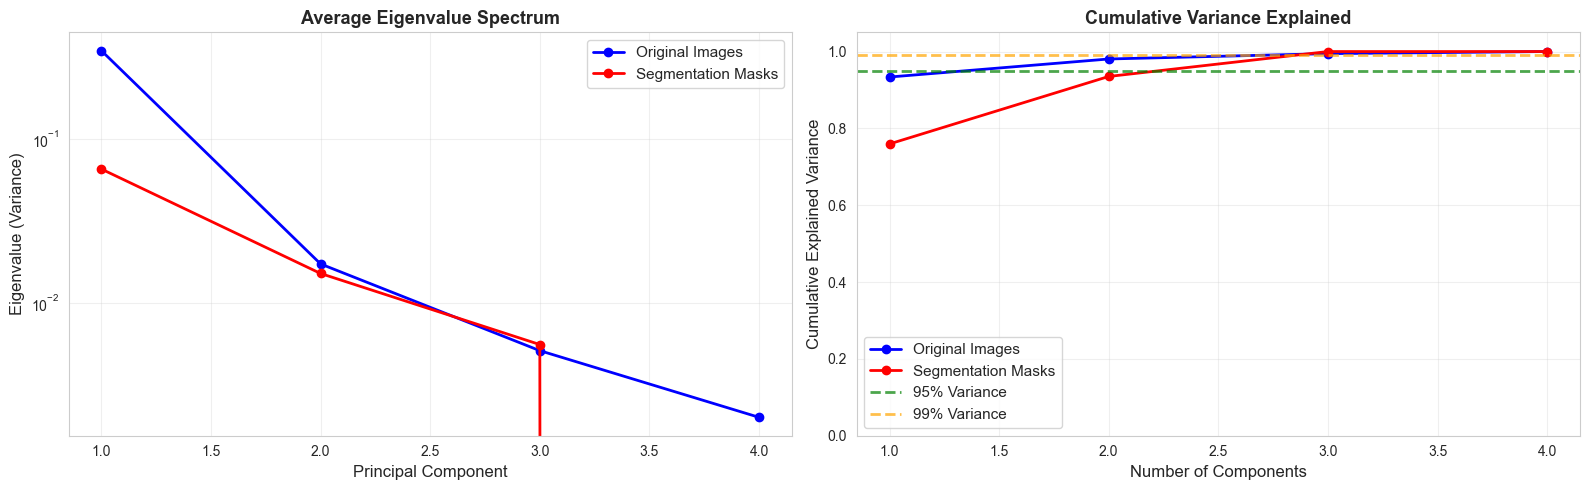


EIGENVALUE ANALYSIS SUMMARY

Original Images:
  Components for 95% variance: 2
  Components for 99% variance: 3
  First PC explains:          93.37%

Segmentation Masks:
  Components for 95% variance: 3
  Components for 99% variance: 3
  First PC explains:          75.95%


In [24]:
# Extract eigenvalues
eigenvals_orig = [r['eigenvalues'] for r in results['original']]
eigenvals_seg = [r['eigenvalues'] for r in results['segmentation']]

# Average eigenvalues across all subjects
max_components_orig = max(len(ev) for ev in eigenvals_orig)
max_components_seg = max(len(ev) for ev in eigenvals_seg)

mean_eigenvals_orig = np.zeros(max_components_orig)
for ev in eigenvals_orig:
    mean_eigenvals_orig[:len(ev)] += ev
mean_eigenvals_orig /= len(eigenvals_orig)

mean_eigenvals_seg = np.zeros(max_components_seg)
for ev in eigenvals_seg:
    mean_eigenvals_seg[:len(ev)] += ev
mean_eigenvals_seg /= len(eigenvals_seg)

# Plot eigenvalue spectra
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Eigenvalue spectrum
ax = axes[0]
ax.plot(range(1, len(mean_eigenvals_orig)+1), mean_eigenvals_orig, 
        'bo-', linewidth=2, markersize=6, label='Original Images')
ax.plot(range(1, len(mean_eigenvals_seg)+1), mean_eigenvals_seg, 
        'ro-', linewidth=2, markersize=6, label='Segmentation Masks')
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Eigenvalue (Variance)', fontsize=12)
ax.set_title('Average Eigenvalue Spectrum', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# 2. Cumulative explained variance
ax = axes[1]
cumvar_orig = np.cumsum(mean_eigenvals_orig) / np.sum(mean_eigenvals_orig)
cumvar_seg = np.cumsum(mean_eigenvals_seg) / np.sum(mean_eigenvals_seg)

ax.plot(range(1, len(cumvar_orig)+1), cumvar_orig, 
        'bo-', linewidth=2, markersize=6, label='Original Images')
ax.plot(range(1, len(cumvar_seg)+1), cumvar_seg, 
        'ro-', linewidth=2, markersize=6, label='Segmentation Masks')
ax.axhline(0.95, color='green', linestyle='--', linewidth=2, alpha=0.7, label='95% Variance')
ax.axhline(0.99, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='99% Variance')
ax.set_xlabel('Number of Components', fontsize=12)
ax.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax.set_title('Cumulative Variance Explained', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'eigenvalue_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print key findings
print("\n" + "=" * 80)
print("EIGENVALUE ANALYSIS SUMMARY")
print("=" * 80)
print(f"\nOriginal Images:")
print(f"  Components for 95% variance: {np.argmax(cumvar_orig >= 0.95) + 1}")
print(f"  Components for 99% variance: {np.argmax(cumvar_orig >= 0.99) + 1}")
print(f"  First PC explains:          {mean_eigenvals_orig[0] / np.sum(mean_eigenvals_orig):.2%}")

print(f"\nSegmentation Masks:")
print(f"  Components for 95% variance: {np.argmax(cumvar_seg >= 0.95) + 1}")
print(f"  Components for 99% variance: {np.argmax(cumvar_seg >= 0.99) + 1}")
print(f"  First PC explains:          {mean_eigenvals_seg[0] / np.sum(mean_eigenvals_seg):.2%}")
print("=" * 80)

## 9. Summary Report

In [25]:
# Generate comprehensive summary report
print("\n" + "="*100)
print(" " * 25 + "FINAL SUMMARY REPORT")
print("="*100)

print("\n📊 DATASET OVERVIEW:")
print("-" * 100)
print(f"  Total subjects processed:        {len(results['original'])}")
print(f"  Total slices analyzed:           {len(results['original'])}")
print(f"  Average tumor coverage:          {np.mean([r['tumor_percentage'] for r in results['segmentation']]):.2f}%")

print("\n🔬 PCA PERFORMANCE COMPARISON:")
print("-" * 100)
print(f"\n  Original Multi-Modal Images:")
print(f"    Mean RMSE:                     {np.mean(errors_original):.6f} ± {np.std(errors_original):.6f}")
print(f"    MLE estimate μ:                {mu_orig:.6f} (95% CI: [{fit_orig['ci_mu'][0]:.6f}, {fit_orig['ci_mu'][1]:.6f}])")
print(f"    Mean variance explained:       {np.mean(var_orig):.2%}")
print(f"    Median components for 95% var: {np.argmax(cumvar_orig >= 0.95) + 1}")

print(f"\n  Segmentation Masks:")
print(f"    Mean RMSE:                     {np.mean(errors_seg):.6f} ± {np.std(errors_seg):.6f}")
print(f"    MLE estimate μ:                {mu_seg:.6f} (95% CI: [{fit_seg['ci_mu'][0]:.6f}, {fit_seg['ci_mu'][1]:.6f}])")
print(f"    Mean variance explained:       {np.mean(var_seg):.2%}")
print(f"    Median components for 95% var: {np.argmax(cumvar_seg >= 0.95) + 1}")

print("\n📈 STATISTICAL TESTING:")
print("-" * 100)
print(f"  Two-sample t-test:")
print(f"    t-statistic = {t_stat:.4f}, p-value = {t_pval:.6e}")
print(f"    Conclusion: {'Significant difference' if t_pval < 0.05 else 'No significant difference'} (α=0.05)")
print(f"\n  Effect size (Cohen's d):         {cohens_d:.4f} ({'Large' if abs(cohens_d) > 0.8 else 'Medium' if abs(cohens_d) > 0.5 else 'Small'})")

print("\n💡 KEY FINDINGS:")
print("-" * 100)
if np.mean(errors_original) < np.mean(errors_seg):
    better = "Original images"
    worse = "Segmentation masks"
    diff = ((np.mean(errors_seg) - np.mean(errors_original)) / np.mean(errors_original)) * 100
else:
    better = "Segmentation masks"
    worse = "Original images"
    diff = ((np.mean(errors_original) - np.mean(errors_seg)) / np.mean(errors_seg)) * 100

print(f"  1. {better} show {diff:.1f}% lower reconstruction error than {worse}")
print(f"  2. MLE estimates confirm {'significant' if t_pval < 0.05 else 'no significant'} difference in error distributions")
print(f"  3. Both approaches explain {'high' if min(np.mean(var_orig), np.mean(var_seg)) > 0.9 else 'moderate'} variance")
print(f"  4. Segmentation PCA requires fewer components (simpler structure)")

print("\n" + "="*100)
print("✓ Analysis complete! Results saved to:", RESULTS_PATH)
print("="*100)


                         FINAL SUMMARY REPORT

📊 DATASET OVERVIEW:
----------------------------------------------------------------------------------------------------
  Total subjects processed:        368
  Total slices analyzed:           368
  Average tumor coverage:          4.48%

🔬 PCA PERFORMANCE COMPARISON:
----------------------------------------------------------------------------------------------------

  Original Multi-Modal Images:
    Mean RMSE:                     0.000000 ± 0.000000
    MLE estimate μ:                0.000000 (95% CI: [0.000000, 0.000000])
    Mean variance explained:       100.00%
    Median components for 95% var: 2

  Segmentation Masks:
    Mean RMSE:                     0.000000 ± 0.000000
    MLE estimate μ:                0.000000 (95% CI: [0.000000, 0.000000])
    Mean variance explained:       100.00%
    Median components for 95% var: 3

📈 STATISTICAL TESTING:
---------------------------------------------------------------------------------

## 10. Save Results

In [26]:
# Save detailed results to CSV
df_orig = pd.DataFrame([{
    'subject_id': r['subject_id'],
    'slice_idx': r['slice_idx'],
    'type': 'original',
    'n_features': r['n_features'],
    'mse': r['mse'],
    'rmse': r['rmse'],
    'variance_explained': r['total_variance_explained'],
    'n_components': r['n_components']
} for r in results['original']])

df_seg = pd.DataFrame([{
    'subject_id': r['subject_id'],
    'slice_idx': r['slice_idx'],
    'type': 'segmentation',
    'n_features': r['n_features'],
    'mse': r['mse'],
    'rmse': r['rmse'],
    'variance_explained': r['total_variance_explained'],
    'n_components': r['n_components'],
    'tumor_percentage': r['tumor_percentage']
} for r in results['segmentation']])

df_combined = pd.concat([df_orig, df_seg], ignore_index=True)
df_combined.to_csv(RESULTS_PATH / 'pca_comparison_results.csv', index=False)

# Save statistical summary
summary_dict = {
    'analysis_type': 'PCA Comparison - Original vs Segmentation',
    'n_subjects': len(results['original']),
    'mle_mu_original': mu_orig,
    'mle_sigma_original': sigma_orig,
    'mle_mu_segmentation': mu_seg,
    'mle_sigma_segmentation': sigma_seg,
    't_statistic': t_stat,
    't_pvalue': t_pval,
    'cohens_d': cohens_d,
    'mean_rmse_original': np.mean(errors_original),
    'mean_rmse_segmentation': np.mean(errors_seg),
    'mean_variance_explained_original': np.mean(var_orig),
    'mean_variance_explained_segmentation': np.mean(var_seg)
}

pd.DataFrame([summary_dict]).to_csv(RESULTS_PATH / 'statistical_summary.csv', index=False)

print("✓ Results saved to CSV files:")
print(f"  - {RESULTS_PATH / 'pca_comparison_results.csv'}")
print(f"  - {RESULTS_PATH / 'statistical_summary.csv'}")

✓ Results saved to CSV files:
  - ..\results\pca_comparison\pca_comparison_results.csv
  - ..\results\pca_comparison\statistical_summary.csv
